In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import yfinance
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data\df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

#plt.figure(figsize=(12, 6))
#plt.plot(ts)
#plt.title('Prix journaliers du S&P500')
#plt.show()

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')


<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\2850176252.py:13: SyntaxWarning: invalid escape sequence '\d'
  data = pd.read_csv('data\df.csv',sep='|')
[*********************100%***********************]  1 of 1 completed


=== SARIMAX ENRICHI POUR S&P 500 ===

1. Chargement des données...
Données d'exemple créées.

2. Création des variables techniques...
Variables créées. Nouvelles dimensions: (1305, 6)

3. Sélection des variables exogènes...
Variables exogènes sélectionnées (5):
 1. Open
 2. High
 3. Low
 4. Volume
 5. VIX

4. Ajustement du modèle SARIMAX...
Ajustement SARIMAX(1, 1, 1)x(1, 0, 1, 5)
Données: 1305 observations
Variables exogènes: 5
Modèle ajusté avec succès!
AIC: 3600.99
Log-likelihood: -1789.50

5. Analyse des variables...
Aucune variable exogène détectée dans le modèle.

6. Génération des prévisions...


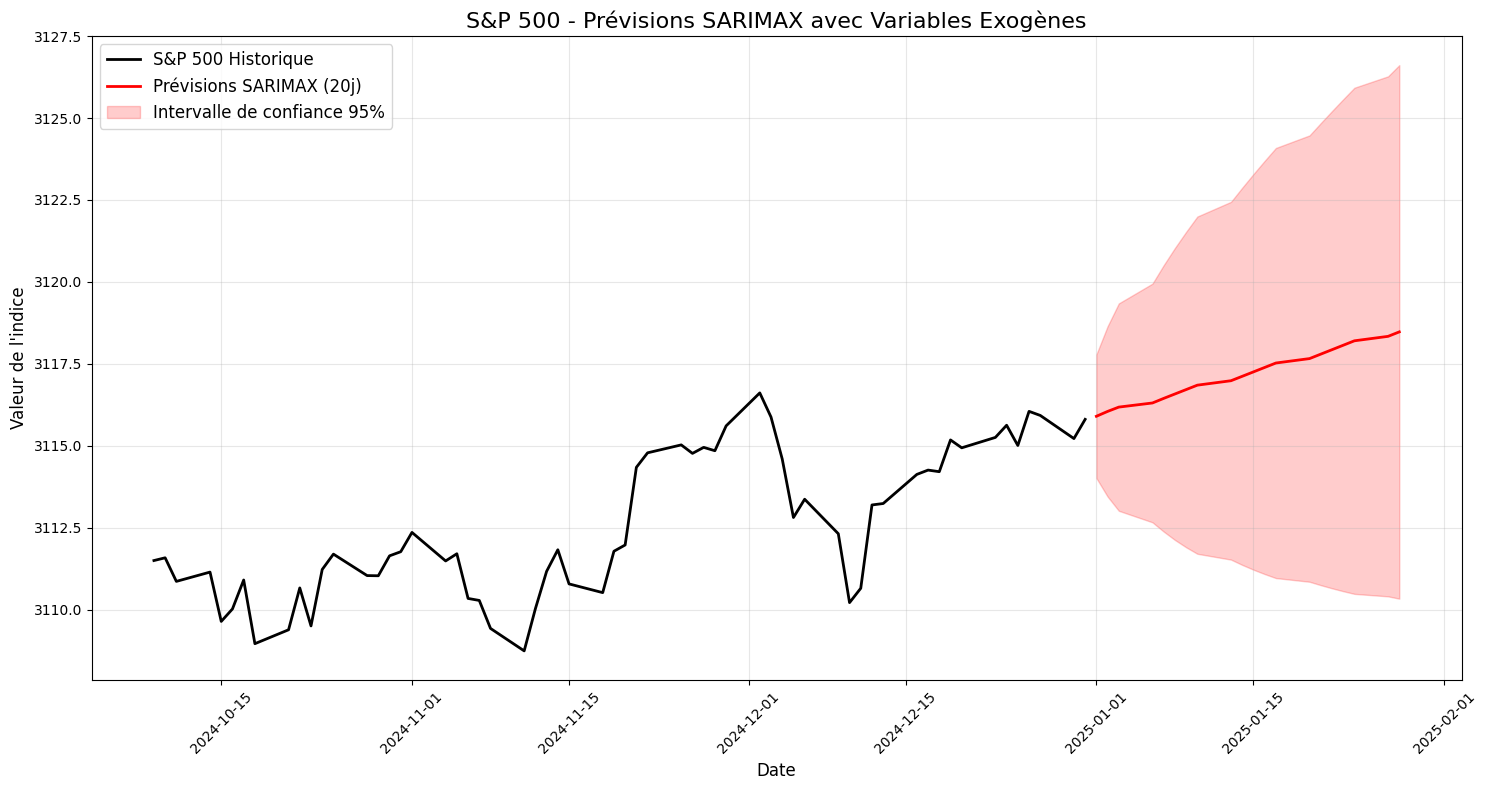


7. Résumé du modèle:
                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                 1305
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -1789.496
Date:                           Wed, 01 Oct 2025   AIC                           3600.992
Time:                                   12:14:09   BIC                           3657.838
Sample:                               01-01-2020   HQIC                          3622.323
                                    - 12-31-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001   4.25e-05      3.046      0.002    4.61e-05       0.000
Open           0.0444

In [6]:
class SP500SARIMAXForecaster:
    """
    Modèle SARIMAX pour S&P 500 avec variables exogènes
    """
    
    def __init__(self):
        self.model = None
        self.fitted_model = None
        self.data = None
        self.exog_vars = None
        self.feature_names = []
        self.is_fitted = False
        
    def load_data(self, file_path):
        """
        Charge les données depuis le fichier Excel
        """
        try:
            # Lire le fichier Excel
            df = pd.read_csv('data\df.csv',sep='|')
            
            # Détecter la colonne de date
            date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
            if date_cols:
                df[date_cols[0]] = pd.to_datetime(df[date_cols[0]])
                df.set_index(date_cols[0], inplace=True)
            else:
                print("Aucune colonne de date détectée. Veuillez spécifier manuellement.")
                
            self.data = df
            return df
            
        except Exception as e:
            print(f"Erreur lors du chargement: {e}")
            return None
    
    def create_market_features(self, target_column='cible'):
        """
        Crée des variables techniques et calendaires utiles pour le S&P 500
        
        Parameters:
        -----------
        target_column : str
            Nom de la colonne contenant les prix du S&P 500
        """
        if self.data is None:
            raise ValueError("Données non chargées. Utilisez load_data() d'abord.")
            
        df = self.data.copy()
        
        # === VARIABLES TECHNIQUES ===
        
        # 1. Rendements et volatilité
        if target_column in df.columns:
            df['returns'] = df[target_column].pct_change()
            df['log_returns'] = np.log(df[target_column] / df[target_column].shift(1))
            
            # Volatilité réalisée (rolling)
            df['volatility_5d'] = df['returns'].rolling(5).std()
            df['volatility_20d'] = df['returns'].rolling(20).std()
        
        # 2. Moyennes mobiles et signaux techniques
        if target_column in df.columns:
            df['mov_avg_10d'] = df['mov_avg_10d']
            df['mov_avg_20d'] = df['mov_avg_20d']
            df['mov_avg_30d'] = df['mov_avg_30d']
            df['mov_avg_50d'] = df['mov_avg_50d']
            df['mov_avg_100d'] = df['mov_avg_100d']
            df['mov_avg_200d'] = df['mov_avg_200d']
            
            # Signaux techniques
            df['ma_signal_short'] = (df[target_column] > df['mov_avg_10d']).astype(int)
            df['ma_signal_long'] = (df[target_column] > df['mov_avg_50d']).astype(int)
        
        # 3. Volume (si disponible)
        if 'volume' in df.columns:
            df['volume_ma_20'] = df['volume'].rolling(20).mean()
            df['volume_ratio'] = df['volume'] / df['volume_ma_20']
            df['high_volume'] = (df['volume_ratio'] > 1.5).astype(int)
        
        # === VARIABLES MACRO-ÉCONOMIQUES (si disponibles) ===        
        
        self.data = df
        print(f"Variables créées. Nouvelles dimensions: {df.shape}")
        return df
    
    def select_exog_variables(self, target_column='close', method='correlation'):
        """
        Sélectionne les meilleures variables exogènes
        
        Parameters:
        -----------
        target_column : str
            Variable cible (S&P 500)
        method : str
            'correlation', 'all', ou liste des noms de variables
        """
        if self.data is None:
            raise ValueError("Données non disponibles.")
            
        # Variables candidates (exclure la cible et variables avec trop de NaN)
        exclude_cols = [target_column, 'returns', 'log_returns'] + \
                      [col for col in self.data.columns if self.data[col].isna().sum() > len(self.data) * 0.1]
        
        candidate_vars = [col for col in self.data.columns if col not in exclude_cols and 
                         self.data[col].dtype in ['int64', 'float64', 'bool']]
        
        if method == 'all':
            selected_vars = candidate_vars
        elif method == 'correlation':
            # Sélection basée sur la corrélation avec les rendements
            if 'returns' in self.data.columns:
                correlations = self.data[candidate_vars + ['returns']].corr()['returns'].abs().sort_values(ascending=False)
                # Prendre les 15 variables les plus corrélées
                selected_vars = correlations.head(16).index.tolist()
                selected_vars.remove('returns') if 'returns' in selected_vars else None
            else:
                selected_vars = candidate_vars[:15]  # Limiter à 15 variables
        elif isinstance(method, list):
            selected_vars = [var for var in method if var in candidate_vars]
        else:
            selected_vars = candidate_vars[:10]
        
        # Préparer les données exogènes
        exog_data = self.data[selected_vars].fillna(method='ffill').fillna(0)
        self.exog_vars = exog_data
        self.feature_names = selected_vars
        
        print(f"Variables exogènes sélectionnées ({len(selected_vars)}):")
        for i, var in enumerate(selected_vars, 1):
            print(f"{i:2d}. {var}")
            
        # Montrer les corrélations si disponibles
        if 'returns' in self.data.columns:
            print(f"\nCorrélations avec les rendements:")
            corr_with_returns = self.data[selected_vars + ['returns']].corr()['returns'].abs().sort_values(ascending=False)
            for var in corr_with_returns.head(5).index:
                if var != 'returns':
                    print(f"   {var}: {corr_with_returns[var]:.3f}")
        
        return exog_data
    
    def fit_sarimax_model(self, target_column='close', 
                         order=(1,1,1), seasonal_order=(1,0,1,5)):
        """
        Ajuste le modèle SARIMAX avec variables exogènes
        """
        if self.data is None or self.exog_vars is None:
            raise ValueError("Données ou variables exogènes non préparées.")
            
        target_series = self.data[target_column].dropna()
        
        # Aligner les données exogènes avec la série cible
        common_index = target_series.index.intersection(self.exog_vars.index)
        target_aligned = target_series.loc[common_index]
        exog_aligned = self.exog_vars.loc[common_index]
        
        print(f"Ajustement SARIMAX{order}x{seasonal_order}")
        print(f"Données: {len(target_aligned)} observations")
        print(f"Variables exogènes: {len(self.feature_names)}")
        
        try:
            self.model = SARIMAX(
                target_aligned,
                exog=exog_aligned,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                trend='t'
            )
            
            self.fitted_model = self.model.fit(disp=False)
            self.is_fitted = True
            
            print(f"Modèle ajusté avec succès!")
            print(f"AIC: {self.fitted_model.aic:.2f}")
            print(f"Log-likelihood: {self.fitted_model.llf:.2f}")
            
            return self.fitted_model
            
        except Exception as e:
            print(f"Erreur lors de l'ajustement: {e}")
            return None
    
    def forecast_with_exog(self, n_periods=10, exog_forecast=None):
        """
        Génère des prévisions avec variables exogènes
        
        Parameters:
        -----------
        n_periods : int
            Nombre de périodes à prédire
        exog_forecast : DataFrame, optional
            Valeurs futures des variables exogènes
            Si None, utilise la dernière valeur observée
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        if exog_forecast is None:
            # Utiliser les dernières valeurs pour les variables exogènes
            last_exog = self.exog_vars.iloc[-1:].copy()
            exog_forecast = pd.concat([last_exog] * n_periods, ignore_index=True)
        
        try:
            forecast = self.fitted_model.forecast(steps=n_periods, exog=exog_forecast)
            conf_int = self.fitted_model.get_forecast(steps=n_periods, exog=exog_forecast).conf_int()
            
            return forecast, conf_int
            
        except Exception as e:
            print(f"Erreur lors de la prévision: {e}")
            return None, None
    
    def plot_forecast(self, target_column='close', n_periods=10, figsize=(15, 8)):
        """
        Visualise les prévisions SARIMAX
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        forecast, conf_int = self.forecast_with_exog(n_periods)
        
        if forecast is None:
            return
            
        # Données récentes
        recent_data = self.data[target_column].dropna()[-60:]
        
        # Dates futures
        last_date = recent_data.index[-1]
        future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_periods)
        
        plt.figure(figsize=figsize)
        
        # Données historiques
        plt.plot(recent_data.index, recent_data, 
                label='S&P 500 Historique', color='black', linewidth=2)
        
        # Prévisions
        plt.plot(future_dates, forecast, 
                label=f'Prévisions SARIMAX ({n_periods}j)', 
                color='red', linewidth=2)
        
        # Intervalles de confiance
        plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                        color='red', alpha=0.2, label='Intervalle de confiance 95%')
        
        plt.title('S&P 500 - Prévisions SARIMAX avec Variables Exogènes', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Valeur de l\'indice', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return forecast, conf_int
    
    def feature_importance(self):
        """
        Analyse l'importance des variables exogènes
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        # Coefficients des variables exogènes
        params = self.fitted_model.params
        exog_params = params[params.index.str.contains('x')]  # Variables exogènes sont préfixées 'x'
        
        if len(exog_params) > 0:
            # Créer un DataFrame avec les coefficients
            importance_df = pd.DataFrame({
                'Variable': self.feature_names[:len(exog_params)],
                'Coefficient': exog_params.values,
                'Abs_Coefficient': np.abs(exog_params.values),
                'P_Value': self.fitted_model.pvalues[exog_params.index].values
            }).sort_values('Abs_Coefficient', ascending=False)
            
            print("=== IMPORTANCE DES VARIABLES EXOGÈNES ===")
            print(importance_df.head(10).to_string(index=False))
            
            # Graphique
            top_vars = importance_df.head(10)
            plt.figure(figsize=(12, 8))
            colors = ['red' if coef < 0 else 'green' for coef in top_vars['Coefficient']]
            plt.barh(range(len(top_vars)), top_vars['Coefficient'], color=colors)
            plt.yticks(range(len(top_vars)), top_vars['Variable'])
            plt.xlabel('Coefficient')
            plt.title('Top 10 Variables Exogènes - Impact sur S&P 500')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            return importance_df
        else:
            print("Aucune variable exogène détectée dans le modèle.")
            return None
    
    def summary(self):
        """Résumé du modèle"""
        if self.fitted_model:
            return self.fitted_model.summary()
        else:
            print("Modèle non ajusté.")

# Exemple d'utilisation
if __name__ == "__main__":
    
    print("=== SARIMAX ENRICHI POUR S&P 500 ===\n")
    
    # Initialiser le forecaster
    forecaster = SP500SARIMAXForecaster()

    # Charger les données (remplacer par votre chemin)
    print("1. Chargement des données...")
    # df = forecaster.load_data("sp.xlsx")
    
    # Pour la démonstration, créer des données d'exemple
    dates = pd.bdate_range('2020-01-01', '2024-12-31', freq='B')
    np.random.seed(42)
    
    # Simuler des données S&P 500 avec d'autres variables
    sp500_close = 3000 + np.cumsum(np.random.normal(0.05, 1, len(dates)))
    vix = 20 + np.random.normal(0, 5, len(dates))
    volume = np.random.lognormal(15, 0.3, len(dates))
    
    demo_data = pd.DataFrame({
        'close': sp500_close,
        'Open': sp500_close * (1 + np.random.normal(0, 0.001, len(dates))),
        'High': sp500_close * (1 + np.abs(np.random.normal(0, 0.005, len(dates)))),
        'Low': sp500_close * (1 - np.abs(np.random.normal(0, 0.005, len(dates)))),
        'Volume': volume,
        'VIX': np.maximum(5, vix)  # VIX ne peut pas être négatif
    }, index=dates)
    
    forecaster.data = demo_data
    print("Données d'exemple créées.")
    
    # Créer les variables techniques et calendaires
    print("\n2. Création des variables techniques...")
    forecaster.create_market_features(target_column='cible')
    
    # Sélectionner les variables exogènes
    print("\n3. Sélection des variables exogènes...")
    exog_vars = forecaster.select_exog_variables(target_column='close', method='correlation')
    
    # Ajuster le modèle SARIMAX
    print("\n4. Ajustement du modèle SARIMAX...")
    fitted_model = forecaster.fit_sarimax_model(
        target_column='close',
        order=(1,1,1),
        seasonal_order=(1,0,1,5)
    )
    
    if fitted_model:
        # Analyser l'importance des variables
        print("\n5. Analyse des variables...")
        importance = forecaster.feature_importance()
        
        # Générer des prévisions
        print("\n6. Génération des prévisions...")
        forecast, conf_int = forecaster.plot_forecast(n_periods=20)
        
        # Résumé du modèle
        print("\n7. Résumé du modèle:")
        print(forecaster.summary())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open   Volume
Ticker       DX-Y.NYB   DX-Y.NYB   DX-Y.NYB   DX-Y.NYB DX-Y.NYB
Date                                                           
1999-01-04  93.440002  94.150002  93.050003  93.889999        0
1999-01-05  93.470001  93.820000  93.080002  93.440002        0
1999-01-06  94.529999  94.849998  93.209999  93.739998        0
1999-01-07  93.720001  94.480003  93.449997  94.419998        0
1999-01-08  94.349998  94.820000  93.660004  93.800003        0
...               ...        ...        ...        ...      ...
2025-09-11  97.540001  98.089996  97.470001  97.790001        0
2025-09-12  97.550003  97.860001  97.489998  97.519997        0
2025-09-15  97.300003  97.699997  97.269997  97.629997        0
2025-09-16  96.629997  97.389999  96.559998  97.339996        0
2025-09-17  96.870003  97.070000  96.220001  96.620003        0

[6753 rows x 5 columns]
